## Poisson Goals Match Outcome

**Idea:** train 2 Poisson regressors:
- λ_home = expected home goals
- λ_away = expected away goals

Then convert (λ_home, λ_away) → P(Home/Draw/Away).


In [1]:
!git clone https://github.com/eamtcPROG/AIA.git
%cd AIA
%pip -q install pandas numpy scikit-learn scipy matplotlib

Cloning into 'AIA'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 149 (delta 59), reused 110 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (149/149), 4.26 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/AIA


In [2]:
from __future__ import annotations

import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid

from sklearn.metrics import (
    mean_absolute_error,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    log_loss,
    mean_poisson_deviance,
)


## 2) Load dataset


In [3]:
candidates = [
    Path("../cleared_data/ml_dataset.csv"),
    Path("cleared_data/ml_dataset.csv"),
    Path("ml_dataset.csv"),
]

DATA_PATH = next((p for p in candidates if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError("ml_dataset.csv not found. Expected in ../cleared_data/ or cleared_data/")

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()

for c in ["homeTeam_name", "awayTeam_name"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# targets (goals)
HOME_GOALS = "score_fullTime_home"
AWAY_GOALS = "score_fullTime_away"

df = df.dropna(subset=["homeTeam_name", "awayTeam_name", HOME_GOALS, AWAY_GOALS]).copy()
df[HOME_GOALS] = df[HOME_GOALS].astype(int)
df[AWAY_GOALS] = df[AWAY_GOALS].astype(int)

# if date exists, sort (helps a bit)
if "utcDate" in df.columns:
    df["utcDate"] = pd.to_datetime(df["utcDate"], errors="coerce")
    df = df.sort_values("utcDate").reset_index(drop=True)

df.head()


,awayTeam_name,competition_name,homeTeam_name,matchday,score_fullTime_away,score_fullTime_home,score_halfTime_away,score_halfTime_home,match_outcome,home_points,...,goals_against_diff,points_diff,position_diff,home_advantage_metric,top_scorer_goals_diff,top3_goals_diff,scoring_depth_diff,num_scorers_diff,total_goals,goal_margin
0,Rayo Vallecano de Madrid,Primera Division,UD Almería,1,2,0,2.0,0.0,0.0,21,...,27,-31,-10,-13,3.0,4.0,-2.0,-1.0,2.0,-2.0
1,Valencia CF,Primera Division,Sevilla FC,1,2,1,0.0,0.0,0.0,41,...,1,-8,-4,8,3.0,-2.0,-24.0,-4.0,3.0,-1.0
2,Girona FC,Primera Division,Real Sociedad de Fútbol,1,1,1,0.0,1.0,1.0,60,...,-14,-21,-3,3,-15.0,-19.0,-19.0,-1.0,2.0,0.0
3,RCD Mallorca,Primera Division,UD Las Palmas,1,1,1,0.0,1.0,1.0,40,...,17,-8,-6,1,0.0,1.0,-6.0,-1.0,2.0,0.0
4,Real Madrid CF,Primera Division,Athletic Club,1,2,0,2.0,0.0,0.0,70,...,-1,-25,-3,-1,-16.0,-27.0,-61.0,-4.0,2.0,-2.0


## 3) Feature engineering


In [4]:
def outcome_from_goals(hg: int, ag: int) -> int:
    # 0 = draw, 1 = away won, 2 = home won
    if hg == ag:
        return 0
    return 2 if hg > ag else 1

df["match_outcome"] = [outcome_from_goals(h, a) for h, a in zip(df[HOME_GOALS], df[AWAY_GOALS])]

# leakage columns: anything that is (or uses) the final score
leakage = set([
    "match_outcome",
    HOME_GOALS, AWAY_GOALS,
    "score_halfTime_home", "score_halfTime_away",
    "total_goals", "goal_margin",
])

# drop any score_* columns if present
for col in df.columns:
    if col.startswith("score_"):
        leakage.add(col)

feature_cols = [c for c in df.columns if c not in leakage]

categorical_cols = [c for c in feature_cols if df[c].dtype == "object"]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

# keep team names in categorical (important)
for c in ["homeTeam_name", "awayTeam_name"]:
    if c in feature_cols and c not in categorical_cols:
        categorical_cols.append(c)

print("features:", len(feature_cols))
print("categorical:", len(categorical_cols))
print("numeric:", len(numeric_cols))


features: 79
categorical: 3
numeric: 76


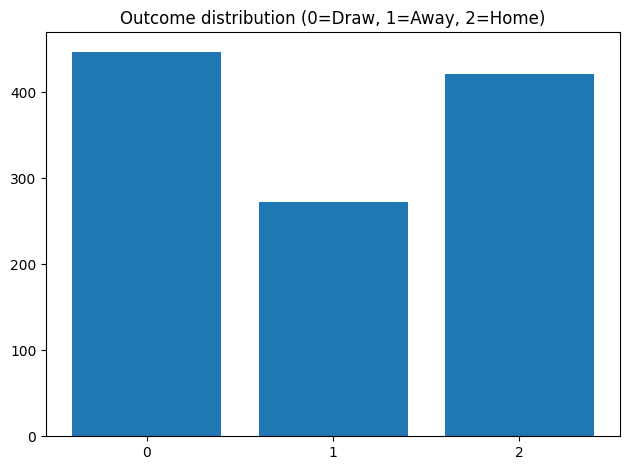

In [5]:
# quick look at outcome distribution
plt.figure()
vc = df["match_outcome"].value_counts().sort_index()
plt.bar(vc.index.astype(str), vc.values)
plt.title("Outcome distribution (0=Draw, 1=Away, 2=Home)")
plt.tight_layout()
plt.show()


## 4) Train/test split (80%/20%)


In [6]:
X = df[feature_cols].copy()
y_home = df[HOME_GOALS].values
y_away = df[AWAY_GOALS].values
y_outcome = df["match_outcome"]

# keep draw/away/home proportions similar
X_train, X_test, yH_train, yH_test, yA_train, yA_test, yO_train, yO_test = train_test_split(
    X, y_home, y_away, y_outcome,
    test_size=0.2,
    random_state=42,
    stratify=y_outcome
)

print("train:", len(X_train), "test:", len(X_test))
print("train outcome dist:", yO_train.value_counts().sort_index().to_dict())
print("test outcome dist :", yO_test.value_counts().sort_index().to_dict())


train: 912 test: 228
train outcome dist: {0: 358, 1: 217, 2: 337}
test outcome dist : {0: 89, 1: 55, 2: 84}


## 5) Pipeline + tuning (PoissonRegressor)


In [7]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", SimpleImputer(strategy="median"), numeric_cols),
    ],
    remainder="drop",
)

base_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", PoissonRegressor(max_iter=5000, tol=1e-7)),
])

param_grid = {
    "model__alpha": [0.01, 0.05, 0.1, 0.3, 0.7, 1.0],
    "model__fit_intercept": [True, False],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_home = GridSearchCV(base_pipe, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)
grid_away = GridSearchCV(base_pipe, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)

grid_home.fit(X_train, yH_train)
grid_away.fit(X_train, yA_train)

m_home = grid_home.best_estimator_
m_away = grid_away.best_estimator_

print("best home:", grid_home.best_params_)
print("best away:", grid_away.best_params_)


best home: {'model__alpha': 1.0, 'model__fit_intercept': True}
best away: {'model__alpha': 1.0, 'model__fit_intercept': False}


## 6) Goal prediction quality


home MAE 0.9160681213426298 RMSE 1.1780370774637268 PoissonDeviance 1.253356528561604
away MAE 0.8293639127611264 RMSE 1.0220148877142596 PoissonDeviance 1.2443949805262577


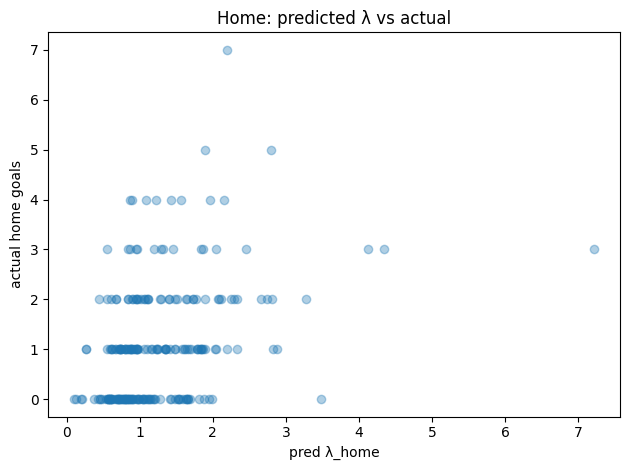

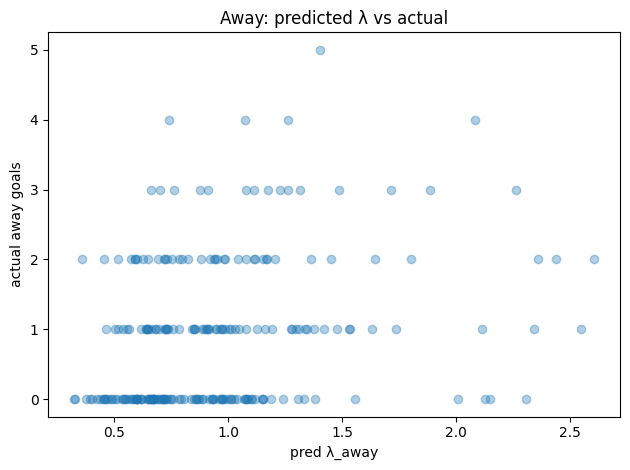

In [8]:
def eval_reg(name, y_true, y_pred):
    print(name,
          "MAE", mean_absolute_error(y_true, y_pred),
          "RMSE", np.sqrt(np.mean((y_true - y_pred)**2)),
          "PoissonDeviance", mean_poisson_deviance(y_true, np.maximum(y_pred, 1e-9)))

predH = m_home.predict(X_test)
predA = m_away.predict(X_test)

eval_reg("home", yH_test, predH)
eval_reg("away", yA_test, predA)

plt.figure()
plt.scatter(predH, yH_test, alpha=0.35)
plt.xlabel("pred λ_home"); plt.ylabel("actual home goals")
plt.title("Home: predicted λ vs actual")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(predA, yA_test, alpha=0.35)
plt.xlabel("pred λ_away"); plt.ylabel("actual away goals")
plt.title("Away: predicted λ vs actual")
plt.tight_layout()
plt.show()


## 7) Convert λ to outcome probabilities


In [9]:
def outcome_probs(lh: float, la: float, max_goals: int = 10):
    hg = poisson.pmf(np.arange(max_goals + 1), mu=lh)
    ag = poisson.pmf(np.arange(max_goals + 1), mu=la)
    mat = np.outer(hg, ag)
    p_home = np.tril(mat, k=-1).sum()
    p_draw = np.trace(mat)
    p_away = np.triu(mat, k=1).sum()
    return float(p_draw), float(p_away), float(p_home)  # order: (0 draw, 1 away, 2 home)

lam_home = np.maximum(predH, 1e-9)
lam_away = np.maximum(predA, 1e-9)

probs = np.array([outcome_probs(h, a, 10) for h, a in zip(lam_home, lam_away)])
P0, P1, P2 = probs[:,0], probs[:,1], probs[:,2]


## 8) Make draws appear (calibrate draw decision)


In [10]:
# Raw argmax often predicts few draws. Tune small draw rule on a validation split from train.
X_tr2, X_val2, yO_tr2, yO_val2 = train_test_split(
    X_train, yO_train,
    test_size=0.2,
    random_state=42,
    stratify=yO_train
)

# lambdas on val
lh_val = np.maximum(m_home.predict(X_val2), 1e-9)
la_val = np.maximum(m_away.predict(X_val2), 1e-9)
pv = np.array([outcome_probs(h, a, 10) for h, a in zip(lh_val, la_val)])
valP = pd.DataFrame({"P0": pv[:,0], "P1": pv[:,1], "P2": pv[:,2]})

def predict_outcome_with_draw(P: pd.DataFrame, delta=0.08, gamma=0.0):
    P = P.copy()
    if gamma != 0:
        P["P0"] = P["P0"] * (1.0 + gamma)
        s = P[["P0","P1","P2"]].sum(axis=1)
        P["P0"] /= s; P["P1"] /= s; P["P2"] /= s

    best = P[["P0","P1","P2"]].max(axis=1)
    base = P[["P0","P1","P2"]].idxmax(axis=1).map({"P0":0, "P1":1, "P2":2})
    pred = np.where(P["P0"] >= best - delta, 0, base)
    return pred, P

grid = list(ParameterGrid({
    "delta": [0.02, 0.05, 0.08, 0.12, 0.18],
    "gamma": [0.0, 0.5, 1.0, 1.5, 2.0],
}))

best_cfg, best_f1 = None, -1
for cfg in grid:
    pred, _ = predict_outcome_with_draw(valP, **cfg)
    score = f1_score(yO_val2, pred, average="macro")
    if score > best_f1:
        best_f1 = score
        best_cfg = cfg

print("best draw cfg:", best_cfg, "macroF1:", best_f1)


best draw cfg: {'delta': 0.05, 'gamma': 0.5} macroF1: 0.5532255682073611


## 9) Outcome evaluation (test set)


Accuracy: 0.5131578947368421
              precision    recall  f1-score   support

           0       0.46      0.60      0.52        89
           1       0.53      0.29      0.38        55
           2       0.59      0.57      0.58        84

    accuracy                           0.51       228
   macro avg       0.53      0.49      0.49       228
weighted avg       0.52      0.51      0.51       228



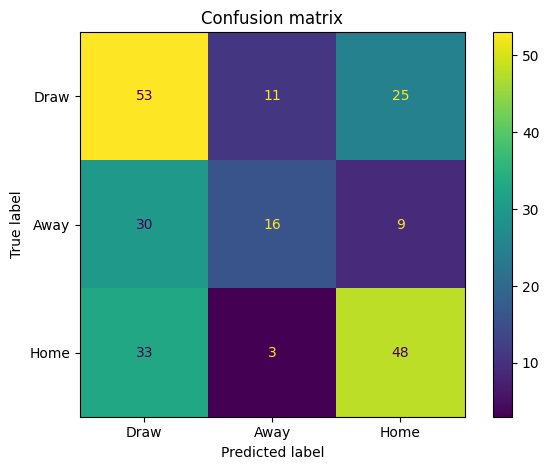

LogLoss: 0.9568605612184671


In [11]:
testP = pd.DataFrame({"P0": P0, "P1": P1, "P2": P2})
pred_out, testP2 = predict_outcome_with_draw(testP, **best_cfg)

print("Accuracy:", accuracy_score(yO_test, pred_out))
print(classification_report(yO_test, pred_out))

cm = confusion_matrix(yO_test, pred_out, labels=[0,1,2])
ConfusionMatrixDisplay(cm, display_labels=["Draw","Away","Home"]).plot()
plt.title("Confusion matrix")
plt.tight_layout()
plt.show()

# log loss over probabilities (0/1/2)
proba = testP2[["P0","P1","P2"]].to_numpy()
print("LogLoss:", log_loss(yO_test, proba, labels=[0,1,2]))


## 10) Feature weights (Poisson coefficients)


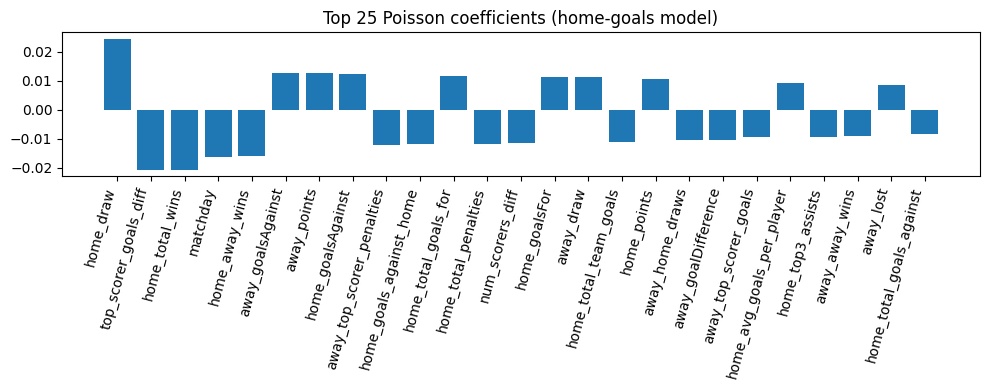

In [12]:
# show biggest coefficients (home model)
ohe = m_home.named_steps["preprocess"].named_transformers_["cat"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
all_names = cat_names + numeric_cols

coefs = m_home.named_steps["model"].coef_
top = pd.DataFrame({"feature": all_names, "coef": coefs})
top["abs"] = top["coef"].abs()
top = top.sort_values("abs", ascending=False).head(25)

plt.figure(figsize=(10,4))
plt.bar(top["feature"], top["coef"])
plt.xticks(rotation=75, ha="right")
plt.title("Top 25 Poisson coefficients (home-goals model)")
plt.tight_layout()
plt.show()


## 11) Predict function


In [13]:
def predict_fixture(home_team: str, away_team: str) -> pd.Series:
    # build a feature row using medians for numeric, mode for categorical
    train_df = df.loc[X_train.index]  # training part of original df

    feature_row = {}

    for col in categorical_cols:
        if col == "homeTeam_name":
            feature_row[col] = home_team
        elif col == "awayTeam_name":
            feature_row[col] = away_team
        else:
            feature_row[col] = train_df[col].mode().iloc[0] if col in train_df.columns and len(train_df[col].mode()) else str(train_df[col].iloc[0])

    for col in numeric_cols:
        feature_row[col] = float(train_df[col].median()) if col in train_df.columns else 0.0

    X1 = pd.DataFrame([feature_row])

    lh = float(np.maximum(m_home.predict(X1)[0], 1e-9))
    la = float(np.maximum(m_away.predict(X1)[0], 1e-9))
    p0, p1, p2 = outcome_probs(lh, la, 10)

    P = pd.DataFrame([{"P0": p0, "P1": p1, "P2": p2}])
    pred, Pn = predict_outcome_with_draw(P, **best_cfg)

    lab = {0:"Draw", 1:"Away Won", 2:"Home Won"}[int(pred[0])]
    return pd.Series({
        "homeTeam": home_team,
        "awayTeam": away_team,
        "lambda_home": lh,
        "lambda_away": la,
        "prediction": lab,
        "p_Draw": float(Pn["P0"].iloc[0]),
        "p_AwayWon": float(Pn["P1"].iloc[0]),
        "p_HomeWon": float(Pn["P2"].iloc[0]),
        **best_cfg,
    })

# example
ex = df[["homeTeam_name","awayTeam_name"]].head(5)
pd.DataFrame([predict_fixture(r.homeTeam_name, r.awayTeam_name) for r in ex.itertuples(index=False)])


,homeTeam,awayTeam,lambda_home,lambda_away,prediction,p_Draw,p_AwayWon,p_HomeWon,delta,gamma
0,UD Almería,Rayo Vallecano de Madrid,1.198420,0.845607,Draw,0.389019,0.226273,0.384708,0.05,0.5
1,Sevilla FC,Valencia CF,1.201730,0.845724,Draw,0.388551,0.225839,0.385610,0.05,0.5
2,Real Sociedad de Fútbol,Girona FC,1.200116,0.847954,Draw,0.388651,0.226654,0.384695,0.05,0.5
3,UD Las Palmas,RCD Mallorca,1.205557,0.850736,Draw,0.387740,0.226623,0.385637,0.05,0.5
4,Athletic Club,Real Madrid CF,1.200789,0.849533,Draw,0.388468,0.226976,0.384555,0.05,0.5
